In [8]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import plotly.graph_objs as go
import numpy as np
import time

In [9]:
#matplotlib plotting
#
def plot_rssi(t, rssi):
    # compute histogram fast
    hist = np.array(np.unique(rssi, return_counts=True)).T
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005


    rect_scatter = [left, bottom, width, height]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(figsize=(16, 8))

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)

    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    ax_scatter.plot(t, rssi,'.',  markersize=1)

    ax_histy.barh(hist[:,0], hist[:,1])
    ax_histy.set_ylim(ax_scatter.get_ylim())
    return ax_scatter, ax_histy
    #plt.show()

In [10]:
# Plotly plotting

def plotly_rssi(t,rssi):
    #. Adapted from https://github.com/plotly/plotly.py/issues/1445
    fig = go.FigureWidget()
    fig.add_scattergl(x=t, y=rssi, mode='markers', name='rssi_vs_time', 
                      marker = dict(size=5, symbol='cross')
#                              marker = dict(size=5,
#                                            opacity=.7,
#                                            color='white',
#                                            line = dict(width=1, color = '#1f77b4')
#                                           )
                     )

    fig.add_histogram(y=rssi, name='rssi', marker=dict(color='#1f77b4', opacity=0.7), 
                      xaxis='x2'
                     )
    #. Use 'meta' field to hold raw data
    fig.data[1].meta = rssi
    fig.layout = dict(xaxis=dict(domain=[0, 0.85], showgrid=False, zeroline=False),
                      yaxis=dict(domain=[0, 1], showgrid=False, zeroline=False),
                      showlegend=True,
                      margin=dict(t=50),
                      hovermode='closest',
                      bargap=0.5,
                      xaxis2=dict(domain=[0.85, 1], showgrid=False, zeroline=False),
                      height=600,
                     )
    #  Lots of trouble getting the updating the histogram to work... Seems to work now that
    #.  I have wrapped the whole thing in a function... Needed to use the "meta" as a data holder
    #
    def do_zoom(layout, xaxis_range, yaxis_range):
        #global y
        inds = ((xaxis_range[0] <= t) & (t <= xaxis_range[1]) &
                (yaxis_range[0] <= rssi) & (rssi <= yaxis_range[1]))

        with fig.batch_update():
            fig.data[1].y = fig.data[1].meta[inds]

    fig.layout.on_change(do_zoom, 'xaxis.range', 'yaxis.range')

    return fig


In [11]:
fname = 'kim.csv'
def load_data(fname):
    kim = pd.read_csv(fname, skiprows=1)
    f = open(fname, 'rb')
    line = f.readline()
    f.close()
    line = line[1:].decode().strip()
    times = line.split(',')
    times = [int(times[0]), int(times[1])]
    # cleanup whitespaces in column names
    kim.rename(columns=lambda x: x[1:].strip() if x.startswith("#") else x.strip(), inplace=True)
    # cleanup whitespaces in data
    kim = kim.applymap(lambda x: x.strip() if type(x)==str else x)
    #. Add columns in which the time on the dongle is converted UNIX EPOCH time, and "datetime64"
    kim['time'] = (kim['dongle_time']-times[0])/1000 + times[1] - 6*3600
    kim['datetime'] = kim['time'].astype('datetime64[s]')
    return kim
kim = load_data(fname)
saewoo = load_data('saewoo.csv')

(<matplotlib.axes._axes.Axes at 0x11a354890>,
 <matplotlib.axes._axes.Axes at 0x11a448910>)

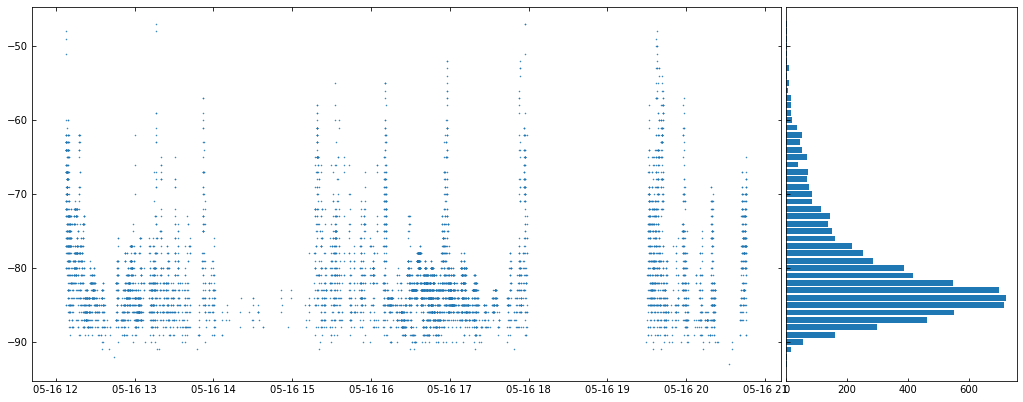

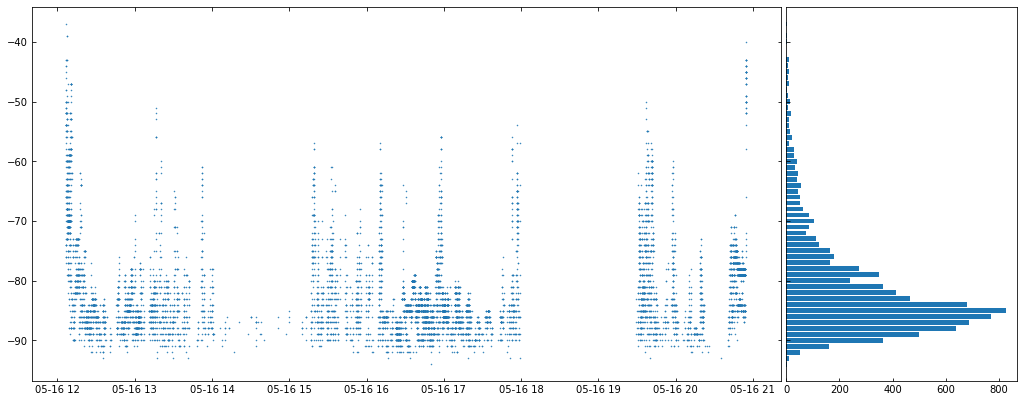

In [12]:
plot_rssi(kim['datetime'], kim['rssi'])
plot_rssi(saewoo['datetime'], saewoo['rssi'])

In [13]:
np.unique(kim['mac'], return_counts=True)

(array(['12:E7:93:AA:F1:A5', '38:8D:EB:4F:EC:0A', 'E0:C1:F2:6C:22:BC',
        'E9:E8:2E:9A:28:FC'], dtype=object),
 array([   8,    2,  214, 7045]))

In [14]:
np.unique(saewoo['mac'], return_counts=True)

(array(['12:E7:93:AA:F1:A5', '38:8D:EB:4F:EC:0A', 'E0:C1:F2:6C:22:BC',
        'EE:AD:79:D5:11:BD'], dtype=object),
 array([   8,    3,  305, 8210]))

In [15]:
xy_data = kim.loc[kim.iloc[:,2]=='E9:E8:2E:9A:28:FC'][['datetime','rssi']]

In [16]:
fig = plotly_rssi(xy_data['datetime'], xy_data['rssi'])
fig

FigureWidget({
    'data': [{'marker': {'size': 5, 'symbol': 'cross'},
              'mode': 'markers',
      …